In [9]:
!pip install pandas xgboost pyarrow google-cloud-bigquery scikit-learn matplotlib db-dtypes


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
PROJECT_ID = 'vertex-ai-test-365213'
LOCATION = "us-central1"
DATASET = "eliasecchi_dev"
TABLE = "transactions__feature_creation_sample"

In [2]:

import datetime
import io
import json
import logging
import pandas as pd

from google.cloud import bigquery
from typing import Dict, List
from google.cloud import bigquery
from xgboost import XGBRegressor

def get_schema_from_query_job(
    client: bigquery.client.Client, query_job: bigquery.job.QueryJob
) -> dict:
    f = io.StringIO("")
    result = query_job.result()
    client.schema_to_json(result.schema, f)
    return json.loads(f.getvalue())


def bq_schema_to_dtypes(bq_schema: List[Dict[str, str]]) -> Dict[str, str]:
    mapping_dict = {
        "STRING": "str",
        "INTEGER": "int",
        "FLOAT": "float",
        "NUMERIC": "float",
        "BOOLEAN": "bool",
    }
    return {column["name"]: mapping_dict.get(column["type"], "object") for column in bq_schema}


def get_casted_df_from_query(client, sql):
    job = client.query(sql)
    bq_schema = get_schema_from_query_job(client=client, query_job=job)
    dtypes = bq_schema_to_dtypes(bq_schema=bq_schema)
    df = job.to_dataframe(dtypes=dtypes)
    return df

client = bigquery.Client(project=PROJECT_ID, location=LOCATION)

In [3]:
# Let's select a sample of our training dataset for the training split
sql = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET}.{TABLE}` 
    WHERE tx_ts >= "2022-06-01" AND tx_ts < "2022-07-01"
    AND ABS(MOD(FARM_FINGERPRINT(tx_id), 100)) = 1 
"""
df_train = get_casted_df_from_query(client=client, sql=sql)

In [4]:
# Let's select a sample of our training dataset for the validation split
sql = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET}.{TABLE}` 
    WHERE tx_ts >= "2022-07-01" AND tx_ts < "2022-07-10"
    AND ABS(MOD(FARM_FINGERPRINT(tx_id), 100)) = 1 
"""

df_val = get_casted_df_from_query(client=client, sql=sql)

In [5]:
EXCLUDE_COLUMNS= ['tx_id','tx_ts','customer_id', 'terminal_id', 'created_timestamp']
CATEGORICAL_COLUMNS = ['day_of_the_week']
LABEL = 'tx_fraud'

training_columns = [column for column in list(df_train.columns) if column not in EXCLUDE_COLUMNS + [LABEL]]

# Setting the type of some columns to category
df_train[CATEGORICAL_COLUMNS] = df_train[CATEGORICAL_COLUMNS].astype('category')
df_val[CATEGORICAL_COLUMNS] = df_train[CATEGORICAL_COLUMNS].astype('category')

In [6]:
x = df_train[training_columns]
y = df_train[[LABEL]]
x_val = df_val[training_columns]
y_val =  df_val[[LABEL]]

In [7]:
model = XGBRegressor(enable_categorical=True, tree_method="hist")
model.fit(x,y, eval_set=[(x_val,y_val)])

[0]	validation_0-rmse:0.35241
[1]	validation_0-rmse:0.25018
[2]	validation_0-rmse:0.18019
[3]	validation_0-rmse:0.13314
[4]	validation_0-rmse:0.10266
[5]	validation_0-rmse:0.08378
[6]	validation_0-rmse:0.07280
[7]	validation_0-rmse:0.06682
[8]	validation_0-rmse:0.06374
[9]	validation_0-rmse:0.06214
[10]	validation_0-rmse:0.06143
[11]	validation_0-rmse:0.06104
[12]	validation_0-rmse:0.05982
[13]	validation_0-rmse:0.05976
[14]	validation_0-rmse:0.05986
[15]	validation_0-rmse:0.05983
[16]	validation_0-rmse:0.05983
[17]	validation_0-rmse:0.05993
[18]	validation_0-rmse:0.05998
[19]	validation_0-rmse:0.06016
[20]	validation_0-rmse:0.06002
[21]	validation_0-rmse:0.05979
[22]	validation_0-rmse:0.05980
[23]	validation_0-rmse:0.05967
[24]	validation_0-rmse:0.05983
[25]	validation_0-rmse:0.05985
[26]	validation_0-rmse:0.05951
[27]	validation_0-rmse:0.05917
[28]	validation_0-rmse:0.05927
[29]	validation_0-rmse:0.05936
[30]	validation_0-rmse:0.05941
[31]	validation_0-rmse:0.05945
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot: >

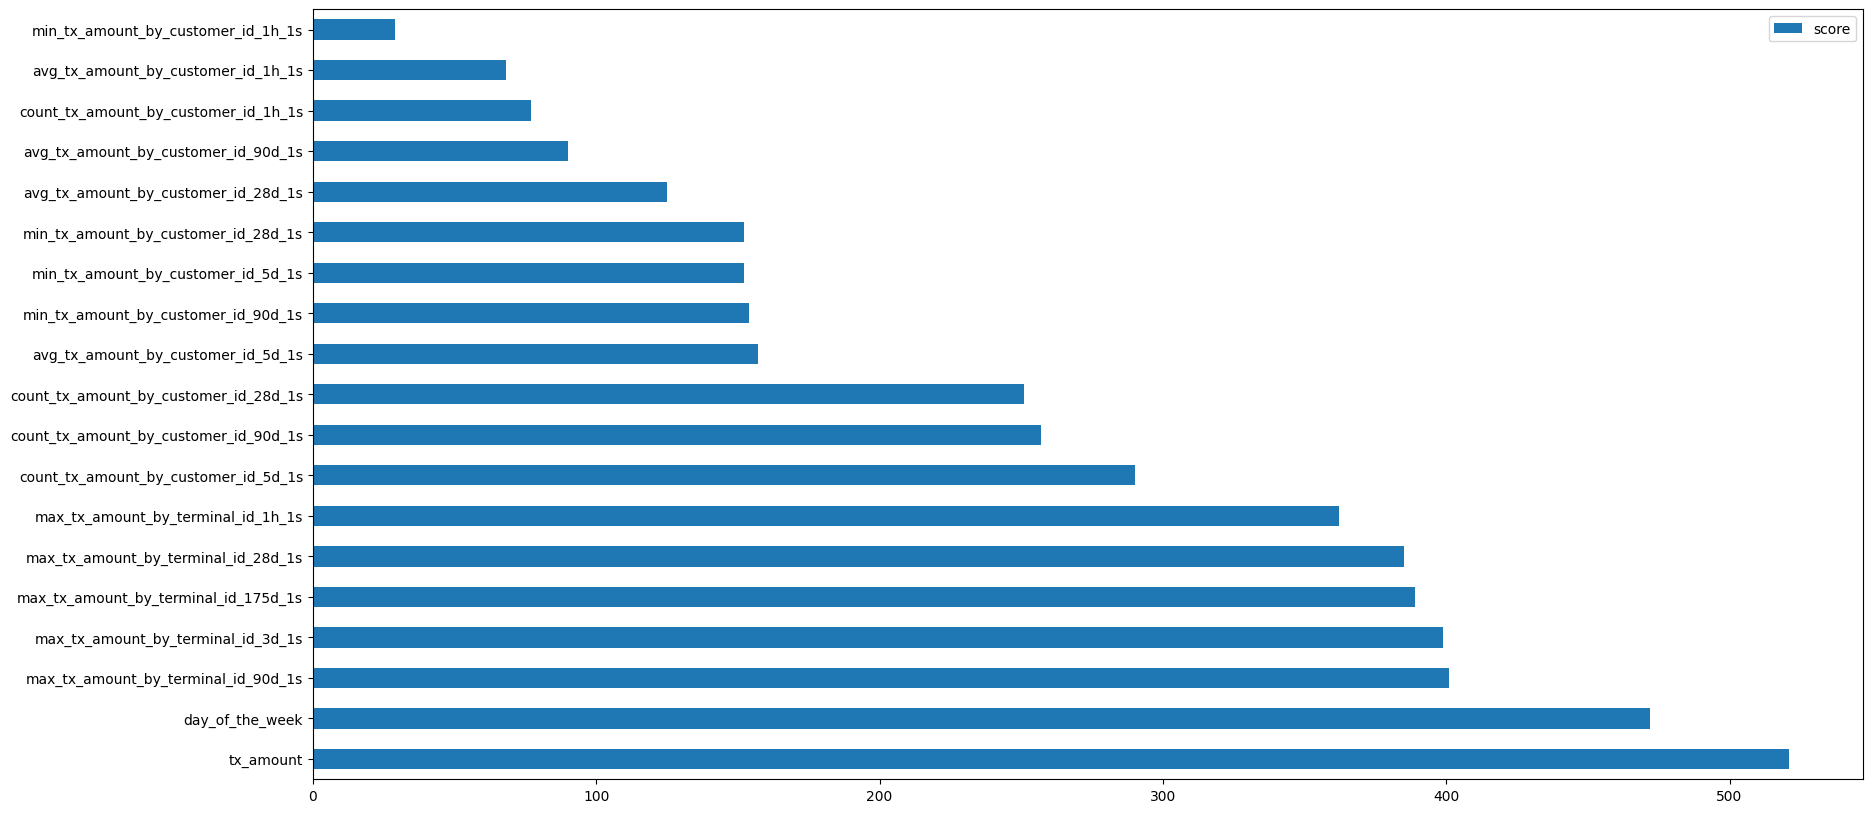

In [8]:
# Print feature importances
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [9]:
x.columns

Index(['tx_amount', 'day_of_the_week', 'count_tx_amount_by_customer_id_1h_1s',
       'count_tx_amount_by_customer_id_5d_1s',
       'count_tx_amount_by_customer_id_28d_1s',
       'count_tx_amount_by_customer_id_90d_1s',
       'avg_tx_amount_by_customer_id_1h_1s',
       'avg_tx_amount_by_customer_id_5d_1s',
       'avg_tx_amount_by_customer_id_28d_1s',
       'avg_tx_amount_by_customer_id_90d_1s',
       'min_tx_amount_by_customer_id_1h_1s',
       'min_tx_amount_by_customer_id_5d_1s',
       'min_tx_amount_by_customer_id_28d_1s',
       'min_tx_amount_by_customer_id_90d_1s',
       'max_tx_amount_by_terminal_id_1h_1s',
       'max_tx_amount_by_terminal_id_3d_1s',
       'max_tx_amount_by_terminal_id_28d_1s',
       'max_tx_amount_by_terminal_id_90d_1s',
       'max_tx_amount_by_terminal_id_175d_1s'],
      dtype='object')